In [1]:
import ujson
import numpy 
import datetime

# Load Data

In [2]:
summaries = {}
ctr = 0
for line in open('user_project_summaries.json'): # lazy iteration because the file is large
    print ctr,
    ctr+=1
    summaries.update(ujson.loads(line))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46


## Language

Create Language Data Set and Initialize Language Codes

In [3]:
'''We are using all the data from the user from whom we we have previously 
classfied what their primary langauge is '''

isocodes = ujson.load(open('isocodes.json'))  # mapping from  iso code to language name
user_langs = ujson.load(open('user_inferredlangs.json'))  # mapping from userid to inferred language
#remove Latin because it's not a reliable inference
#TODO for later: get next-best language besides Latin in the inference function
# remove uncommon languages
lang_counts = {}
for user in user_langs:
    lang = user_langs[user]
    lang_counts[lang] = lang_counts.get(lang, 0) + 1
        
user_langs = {user: lang for user, lang in user_langs.items() if lang!='la' and lang_counts[lang]>=500}

langset = sorted(list(set(user_langs.values())))
lang_num_map = {lang: i for i, lang in enumerate(langset)} #key is langauge isocode, value is number 
print 'lang data created with', len(user_langs), 'users and', len(langset), 'languages'

lang data created with 40875 users and 6 languages


## Time

In [4]:
# time utilities
def convert_time(el):
    """Human readable time"""
    el = int(str(el)[:10])
    return datetime.date.fromtimestamp(el)

def timediff(t1, t2):
    """difference between times (millisec precision) as days"""
    return (t1-t2)/(86400.*1000)

In [5]:
earliest = 1e100
latest = 0

ctr = 0
for user in summaries:
    for project in summaries[user]:
        ctime = summaries[user][project]["**created"]
        if ctime < earliest:
            earliest = ctime
        if ctime > latest:
            latest = ctime
            
    ctr+=1
    if ctr%1000==0:
        print ctr/1000,
            
print
print 'Earliest:', convert_time(earliest) 
print 'Latest:', convert_time(latest)
MAXDUR = 300
MINDUR = 150
# get subset of data from "old" users whose earliest creation date is more than MAXDUR days before the end of the dataset
# (giving them a good chance to stay on for more than MINDUR days),
# AND have activity within MAXDUR days if they are active beyond MINDUR (to be fair to recent users)

old_users = set() 

ctr = 0
for user in summaries:
    ctimes = [project["**created"] for project in summaries[user].values()]
    if ctimes==[]:
        print user, 'has no projects'
        continue
    start_time = min(ctimes)
    if timediff(latest, start_time)>MAXDUR:  # first restrict to old users
        # creation times since start date of user
        ctimes_from_start = [timediff(project["**created"], start_time) for project in summaries[user].values()]  
        # projects created at least MINDUR days after start
        post_mindur = [ctime for ctime in ctimes_from_start if ctime>MINDUR]
        # consider users who either were not active after MINDUR days, or had activity between MINDUR and MAXDUR days
        if post_mindur==[] or len(filter(lambda length: length<=MAXDUR, post_mindur))>0:
            old_users.add(user)
            
    ctr+=1
    if ctr%1000==0:
        print ctr/1000,
        
print
print 'Filtered to', len(old_users), 'users from', len(summaries)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
Earliest: 2013-03-27
Latest: 2016-03-10
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 00999 has no projects

Filtered to 25346 users from 46320


In [6]:
# keys = summaries.keys()[0:10000]
# for user in keys: 
#     projects =  getProjects(user, "LANGUAGE")
#     decileOrphanBlocks(projects)

# Features

In [7]:
from features import *
import features
reload(features)
import sys, os
sys.path.append(os.getcwd())

## Time Features

Get moments from list of project lengths and intervals.

In [8]:
def projectLengthFeatures(projects):
    """moments of project lengths and intervals, as well as number of projects"""
    lengths = getProjectLengths(projects)
    intervals = getProjectIntervals(projects)
    
    #note: feature names are for our reference only
    userDict = {} 
    userDict["mean of lengths"] = numpy.mean(lengths)
    userDict["stddev of lengths"] = numpy.std(lengths)
    userDict["mean of intervals"] = numpy.mean(lengths)
    userDict["stddev of intervals"] = numpy.std(lengths)
    
    userDict["num projects"] = numProjects(projects)
    
    return userDict

Get weekday distibution features.

In [9]:
def dayAnalysisFeatures(projects):
    """number of projects on each day of the week, and the percentage of them on a weekday"""
    byday = numOnDay(projects)

    userDict = {day: byday[i] for i, day in enumerate(["Monday", 
                                                       "Tuesday", 
                                                       "Wednesday", 
                                                       "Thursday", 
                                                       "Friday", 
                                                       "Saturday", 
                                                       "Sunday"])}
    return userDict

Histogram of user's projects in the period.

In [10]:
def decileProjects(projects):
    numbins = 10
    hist = projectsPerUserPeriod(projects, bins=numbins)
    
    userDict = {'decile '+str(i+1): hist[i] for i in range(numbins)}
    return userDict

Here is a function to combine different feature groups.

In [11]:
def combine_featfuncs(funclist):
    def combined(user):
        basedict = funclist[0](user)
        for f in funclist[1:]:
            basedict.update(f(user))
        return basedict
    return combined

## Code Features


In [12]:
def summaryOBlockDecile(projects): 
    hist = decileOrphanBlocks(projects)
    userDict = {'Orphan Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [13]:
def summaryDecileTLBlocks(projects): 
    hist = decileTypesTopLevelBlocks(projects)
    userDict = {'TopLevel Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [14]:
def summaryDecileNumScreens(projects): 
    hist = decileNumScreens(projects)
    userDict = {'NumScreens Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [15]:
def summaryAverages(projects):
    userDict = {} 
    userDict["mean of numScreens"] = numpy.mean(getNumScreens(projects))
    userDict["NB"] = averageNumBlocks(projects)
    userDict["OB"] = getAverageOrphanBlocks(projects)
    
    userDict["TL"] = getAverageTypeTLBlocks(projects)
    userDict["TL2"] = getAverageNumTLBlocks(projects)
    
    userDict["NC"] = averageNumComponents(projects)
    userDict["NTC"] = averageNumTypeComponents(projects)

    userDict["MC"] = aveNumMediaAssets(projects)
    
    userDict["NP"] = averageNumProcedures(projects)
    
    userDict["NS"] = averageNumStrings(projects) 
    
    varList = getAllVariables(projects)
    userDict["local vars"] = varList[0]
    userDict["global vars"] = varList[1]
    
    return userDict

# Classification

Get list of projects for each user.

In [16]:
def getAllProjects(userID): #from summaries
    """list of projects sorted by creation times"""
    projectlist = summaries[userID].values()
    return sorted(projectlist,
                  key=lambda project: project['**created']) 

def projectsInMindur(projectlist):
    """filter projects within user's MINDUR duration from earliest"""
    earliest = projectlist[0]['**created']
    filtered_projects = [projectlist[0]]
    for project in projectlist[1:]:
        if timediff(project['**created'], earliest)>MINDUR:
            break
        filtered_projects.append(project)
    return filtered_projects

def userDuration(projectlist):
    """get the duration (difference between last and earliest creation dates)"""
    return timediff(projectlist[-1]['**created'], projectlist[0]['**created'])

def getProjects(userID, task):
    projectlist = getAllProjects(userID)
    if task == 'LANGUAGE': 
        return projectlist
    if task == 'RETENTION':
        return projectsInMindur(projectlist)

Use the appropriate set of users for each task with labels.

In [17]:
def get_user_labels(task):
    if task == 'RETENTION': 
        return {user: int(userDuration(getAllProjects(user))>MINDUR) for user in old_users}
    if task == 'LANGUAGE':
        return {user: lang_num_map[lang] for user, lang in user_langs.items()}

### Featurizing

In [18]:
# featurizer functions
time_combined = combine_featfuncs([projectLengthFeatures, dayAnalysisFeatures, decileProjects])  
code_combined = combine_featfuncs([summaryDecileNumScreens,summaryOBlockDecile,summaryDecileTLBlocks,summaryAverages]) 

In [19]:
from sklearn.feature_extraction import DictVectorizer

all_features = []
time_features = [] 
code_features = []

TASK = 'LANGUAGE'  # toggle between LANGUAGE and RETENTION
userlabels = get_user_labels(TASK)

y = []
ctr = 0
for user in userlabels:
    projects = getProjects(user, TASK)  # this returns projects sorted by creation date

    y.append(userlabels[user])
    
    time_features.append(time_combined(projects))
    code_features.append(code_combined(projects))
    
    # merge time and code feature dicts
    all_features_user = time_features[-1].copy()
    all_features_user.update(code_features[-1])
    all_features.append(all_features_user)
    
    ctr+=1
    if ctr%1000==0:
        print '.',

y = numpy.array(y)

timevec = DictVectorizer()
Xtime = timevec.fit_transform(time_features) 

codevec = DictVectorizer()
Xcode = codevec.fit_transform(code_features)

allvec = DictVectorizer()
Xall = allvec.fit_transform(all_features)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


Scale and standardize features

In [20]:
from sklearn.preprocessing import scale
# convert to dense matrices since these are dense anyway
Xtime = scale(Xtime.toarray())
Xcode = scale(Xcode.toarray())
Xall = scale(Xall.toarray())

### Model and Prediction

Chance is 0.51429969419
Building a logreg model with 22 time features for LANGUAGE
Fold 1


/Users/emmalurie/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


Fold 2


/Users/emmalurie/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


Fold 3


/Users/emmalurie/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


Confusion matrix, without normalization


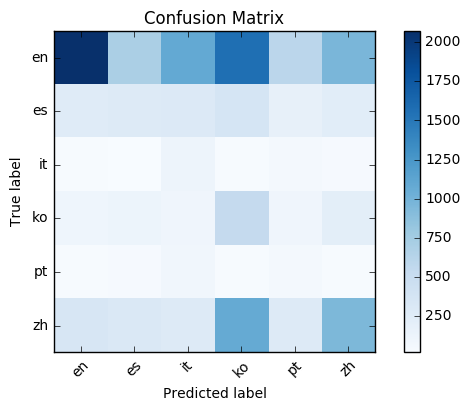

Average accuracy 0.297492187377
Average F1 score 0.340643442926
Building a logreg model with 42 code features for LANGUAGE
Fold 1


/Users/emmalurie/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


Fold 2


/Users/emmalurie/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


Fold 3


/Users/emmalurie/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


Confusion matrix, without normalization


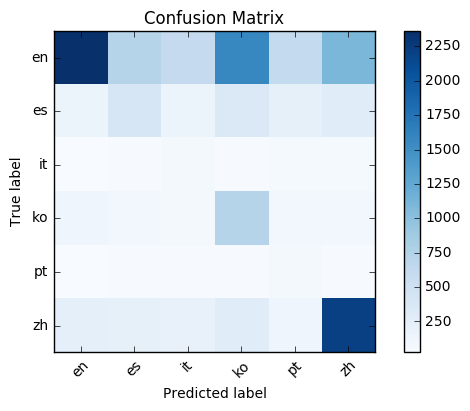

Average accuracy 0.428721864384
Average F1 score 0.45670111154
Building a logreg model with 64 all features for LANGUAGE
Fold 1


/Users/emmalurie/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


Fold 2


/Users/emmalurie/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


Fold 3


/Users/emmalurie/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


Confusion matrix, without normalization


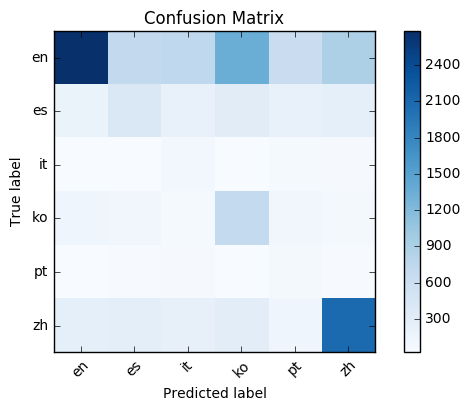

Average accuracy 0.444036723577
Average F1 score 0.48062571136


In [21]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.metrics import f1_score 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline 
from plotcnf import plot_confusion_matrix

print 'Chance is', max(numpy.bincount(y))/float(len(y))

foldindices = StratifiedKFold(y)

if TASK=='LANGUAGE':
    labels = map(lambda x:x[0], sorted(lang_num_map.items(), key=lambda x:x[1]))  
    # languages corresponding to class labels as a list
elif TASK=='RETENTION':
    labels = ['left', 'survived']
    
k = 70 #num neighbors for kNN
if TASK == 'RETENTION':
    classifiers = [('knn', KNeighborsClassifier(n_neighbors=k)), 
                   ('logreg', LogisticRegression())]
else:
    classifiers = [('logreg', LogisticRegression(class_weight='balanced', 
                                                             multi_class='multinomial', 
                                                             solver='lbfgs'))]  # no knn because it's too slow

for modelname, model in classifiers:
    for featname, X in [('time', Xtime), ('code', Xcode), ('all', Xall)]:
        print  'Building a', modelname, 'model with', X.shape[1], featname, 'features for', TASK
    
        cvaccs = numpy.zeros(len(foldindices))
        cvf1 = numpy.zeros(len(foldindices))
        for i, (trainidx, testidx) in enumerate(foldindices):
            print 'Fold', i+1
        
            ytrain = y[trainidx]
            ytest = y[testidx]
        
            Xtrain = X[trainidx, :]  
            Xtest = X[testidx, :]
            
            model.fit(Xtrain, ytrain)
            cvaccs[i] = model.score(Xtest, ytest)
            
            predictions = model.predict(Xtest)
            cvf1[i] = f1_score(ytest, predictions)
        
        # analyze last fold only
        cnf_matrix = confusion_matrix(ytest, predictions)  
        plot_confusion_matrix(cnf_matrix, labels)
        plt.show()
        
        print 'Average accuracy', numpy.mean(cvaccs)
        print 'Average F1 score', numpy.mean(cvf1)

In [22]:
print cvaccs

[ 0.44367799  0.44377569  0.44465649]
